In [24]:
import copy
from collections import defaultdict

import gymnasium
from gymnasium.envs.toy_text.cliffwalking import (
    UP, RIGHT, DOWN, LEFT, POSITION_MAPPING
)
import numpy as np
import tqdm
from IPython import display
from PIL import Image, ImageEnhance
import moviepy.editor as mpy
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

import jax
import jax.numpy as jnp
import flax.linen as nn
import optax

In [25]:
class CliffWalkingEnv(gymnasium.Wrapper):
    def __init__(self, random_init_state=False, max_episode_steps=1000, 
                 render_mode="rgb_array", **kwargs):
        env = gymnasium.make(
            "CliffWalking-v1",
            max_episode_steps=max_episode_steps,
            render_mode=render_mode,
            **kwargs
        )
        super().__init__(env)

        self.nS = self.env.get_wrapper_attr('nS')
        self.nA = self.env.get_wrapper_attr('nA')
        self.shape = self.env.get_wrapper_attr('shape')

        # The original transition probabilities for absorbing states are not correct.
        P = {}
        for s in range(self.nS):
            position = np.unravel_index(s, self.shape)
            P[s] = {a: [] for a in range(self.nA)}
            P[s][UP] = self._calculate_transition_prob(position, UP)
            P[s][RIGHT] = self._calculate_transition_prob(position, RIGHT)
            P[s][DOWN] = self._calculate_transition_prob(position, DOWN)
            P[s][LEFT] = self._calculate_transition_prob(position, LEFT)
        self.env.set_wrapper_attr('P', P)

        if random_init_state:
            initial_state_distrib = np.ones(self.nS)
            cliff_positions = np.asarray(np.where(env.get_wrapper_attr('_cliff')))
            cliff_states = np.ravel_multi_index(cliff_positions, self.shape)
            initial_state_distrib[cliff_states] = 0.0
            initial_state_distrib[47] = 0.0
            initial_state_distrib /= np.sum(initial_state_distrib, keepdims=True)
            self.env.set_wrapper_attr('initial_state_distrib', initial_state_distrib)

        # Calculate transition probabilities and rewards
        rewards = np.full((self.nS, self.nA, self.nS), np.nan)
        transition_probs = np.zeros((self.nS, self.nA, self.nS))
        masks = np.zeros((self.nS, self.nA, self.nS))
        for state in range(self.nS):
            for action in range(self.nA):
                _, next_state, reward, terminated = self.env.get_wrapper_attr('P')[state][action][0]
                rewards[state, action, next_state] = reward
                transition_probs[state, action, next_state] += 1.0
                masks[state, action, next_state] = float(not terminated)
        transition_probs /= np.sum(transition_probs, axis=-1, keepdims=True)
        assert np.all(np.sum(transition_probs, axis=-1) == 1.0)
        reward_max, reward_min = np.nanmax(rewards), np.nanmin(rewards)
        rewards[np.isnan(rewards)] = reward_min
        assert np.all((reward_min <= rewards) & (rewards <= reward_max))

        self._orig_reward_min, self._orig_reward_max = reward_min, reward_max
        self.orig_rewards = rewards
        self.rewards = (rewards - reward_min) / (reward_max - reward_min)
        self.transition_probs = transition_probs
        self.masks = masks

    def _calculate_transition_prob(self, current, move):
        """Determine the outcome for an action. Transition Prob is always 1.0.
        
        The original transition probabilities for absorbing states are not correct.
        """
        if not self.env.get_wrapper_attr('is_slippery'):
            deltas = [POSITION_MAPPING[move]]
        else:
            deltas = [
                POSITION_MAPPING[act] for act in [(move - 1) % 4, move, (move + 1) % 4]
            ]
        outcomes = []

        # the single absorbing state is the goal
        goal_position = np.asarray([self.shape[0] - 1, self.shape[1] - 1])
        goal_state = np.ravel_multi_index(goal_position, self.shape)
        current_position = np.array(current)
        current_state = np.ravel_multi_index(tuple(current_position), self.shape)
        for delta in deltas:
            if current_state == goal_state:
                new_state = current_state
                reward = 0
                is_terminated = True
            else:
                new_position = current_position + np.array(delta)
                new_position = self.env.get_wrapper_attr('_limit_coordinates')(new_position).astype(int)
                new_state = np.ravel_multi_index(tuple(new_position), self.shape)
                if self.env.get_wrapper_attr('_cliff')[tuple(new_position)]:
                    reward = -100
                    new_state = self.env.get_wrapper_attr('start_state_index')
                else:
                    reward = -1
                is_terminated = (new_state == goal_state)
            outcomes.append((1 / len(deltas), new_state, reward, is_terminated))
        return outcomes

    def reset(self, **kwargs):
        obs, info = super().reset(**kwargs)
        self.env.set_wrapper_attr('start_state_index', obs)

        return obs, info

    def step(self, action):
        obs, orig_reward, terminated, truncated, info = super().step(action)
        # reward = (orig_reward - self._orig_reward_min) / (self._orig_reward_max - self._orig_reward_min)
        reward = orig_reward

        return obs, reward, terminated, truncated, info

In [26]:
# collect dataset
discount = 0.95
max_episode_steps = 100
env = CliffWalkingEnv(random_init_state=True, max_episode_steps=max_episode_steps)

# uniform behavioral policy
behavioral_policy = np.ones([env.nS, env.nA]) / env.nA

dataset = defaultdict(list)

# dataset size = 100K
# num_episodes = 5_250
num_episodes = 1000
num_transitions = 0
for _ in tqdm.trange(num_episodes):
    done = False
    obs, info = env.reset()
    # while not done:
    for _ in range(max_episode_steps):
        action = np.random.choice(np.arange(env.nA), p=behavioral_policy[obs])
        next_obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
        num_transitions += 1
        dataset['observations'].append(obs)
        dataset['actions'].append(action)
        dataset['rewards'].append(reward)
        dataset['next_observations'].append(next_obs)
        dataset['masks'].append(not terminated)  # for absorbing states
        dataset['terminals'].append(done)  # for the end of trajectories
        
        obs = next_obs

for k, v in dataset.items():
    if k in ['observations', 'actions', 'next_observations']:
        dtype = np.int32
    elif k == 'terminals':
        dtype = bool
    else:
        dtype = np.float32
    dataset[k] = np.array(v, dtype=dtype)

print("num of total transitions {}".format(num_transitions))

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 327.11it/s]

num of total transitions 100000


In [27]:
print(np.sum(dataset['next_observations'] == 47))

6914


In [28]:
# value iteration to find the optimal Q
rewards = env.rewards
transition_probs = env.transition_probs
# masks = env.masks

# value iteration to find the optimal Q in the original MDP using gamma
opt_q = np.zeros([env.nS, env.nA], dtype=np.float32)
for _ in range(10_000):
  opt_q = (1 - discount) * np.sum(transition_probs * rewards, axis=-1) + discount * np.einsum('ijk,k->ij', transition_probs, np.max(opt_q, axis=-1))
opt_v = np.max(opt_q, axis=-1)

# deterministic optimal policy
opt_policy = np.zeros([env.nS, env.nA])
opt_policy[np.arange(env.nS), np.argmax(opt_q, axis=-1)] = 1.0

# value iteration to find the optimal Q in the original MDP using gamma ** 2
opt_q_square_discount = np.zeros([env.nS, env.nA], dtype=np.float32)
for _ in range(10_000):
  opt_q_square_discount = (1 - discount ** 2) * np.sum(transition_probs * rewards, axis=-1) + discount ** 2 * np.einsum('ijk,k->ij', transition_probs, np.max(opt_q_square_discount, axis=-1))

# value iteration to find the behavioral Q
behavioral_q = np.zeros([env.nS, env.nA], dtype=np.float32)
for _ in range(10_000):
  behavioral_q = (1 - discount) * np.sum(transition_probs * rewards, axis=-1) + discount * np.einsum('ijk,k->ij', transition_probs, np.sum(behavioral_policy * behavioral_q, axis=-1))
behavioral_v = np.sum(behavioral_policy * behavioral_q, axis=-1)

In [29]:
print("optimal q and optimal policy: ")
print(opt_q)
print(opt_policy)

print("behavioral q: ")
print(behavioral_q)

optimal q and optimal policy: 
[[0.99463291 0.99487675 0.99487675 0.99463291]
 [0.99487675 0.99513342 0.99513342 0.99463291]
 [0.99513342 0.9954036  0.9954036  0.99487675]
 [0.9954036  0.995688   0.995688   0.99513342]
 [0.995688   0.99598737 0.99598737 0.9954036 ]
 [0.99598737 0.99630249 0.99630249 0.995688  ]
 [0.99630249 0.9966342  0.9966342  0.99598737]
 [0.9966342  0.99698337 0.99698337 0.99630249]
 [0.99698337 0.99735092 0.99735092 0.9966342 ]
 [0.99735092 0.99773781 0.99773781 0.99698337]
 [0.99773781 0.99814506 0.99814506 0.99735092]
 [0.99814506 0.99814506 0.99857375 0.99773781]
 [0.99463291 0.99513342 0.99513342 0.99487675]
 [0.99487675 0.9954036  0.9954036  0.99487675]
 [0.99513342 0.995688   0.995688   0.99513342]
 [0.9954036  0.99598737 0.99598737 0.9954036 ]
 [0.995688   0.99630249 0.99630249 0.995688  ]
 [0.99598737 0.9966342  0.9966342  0.99598737]
 [0.99630249 0.99698337 0.99698337 0.99630249]
 [0.9966342  0.99735092 0.99735092 0.9966342 ]
 [0.99698337 0.99773781 0.997

In [30]:
def get_video(renders):
    """Return a Weights & Biases video.

    It takes a list of videos and reshapes them into a single video with the specified number of columns.

    Args:
        renders: List of videos. Each video should be a numpy array of shape (t, h, w, c).
        n_cols: Number of columns for the reshaped video. If None, it is set to the square root of the number of videos.
    """
    # Pad videos to the same length.
    max_length = max([len(render) for render in renders])
    for i, render in enumerate(renders):
        assert render.dtype == np.uint8

        # Decrease brightness of the padded frames.
        final_frame = render[-1]
        final_image = Image.fromarray(final_frame)
        enhancer = ImageEnhance.Brightness(final_image)
        final_image = enhancer.enhance(0.5)
        final_frame = np.array(final_image)

        pad = np.repeat(final_frame[np.newaxis, ...], max_length - len(render), axis=0)
        renders[i] = np.concatenate([render, pad], axis=0)

        # Add borders.
        renders[i] = np.pad(renders[i], ((0, 0), (1, 1), (1, 1), (0, 0)), mode='constant', constant_values=0)
    renders = np.array(renders)  # (n, t, h, w, c)

    return renders

In [31]:
# evaluation the optimal pi
max_episode_steps = 100
eval_env = CliffWalkingEnv(random_init_state=True, max_episode_steps=max_episode_steps)

num_episodes = 6
successes = []
renders = []
for _ in tqdm.trange(num_episodes):
    traj_dataset = defaultdict(list)

    done = False
    obs, info = eval_env.reset()
    render = eval_env.render().copy()
    while not done:
        action = np.random.choice(np.arange(eval_env.nA), p=opt_policy[obs])
        next_obs, reward, terminated, truncated, info = eval_env.step(action)
        done = terminated or truncated
        next_render = eval_env.render().copy()
        
        traj_dataset['observations'].append(obs)
        traj_dataset['actions'].append(action)
        traj_dataset['rewards'].append(reward)
        traj_dataset['next_observations'].append(next_obs)
        traj_dataset['renders'].append(render)
        
        obs = next_obs
        render = next_render
    traj_dataset['renders'].append(render)  # append the last frame
    
    successes.append(47 in traj_dataset['next_observations'])
    renders.append(np.asarray(traj_dataset['renders']))

sr = np.mean(successes)
print("success rate = {}".format(sr))

videos = get_video(renders)

fps = 15
num_rows = 2
num_cols = 3
clip_array = []
for row in range(num_rows):
    clip_row = []
    for col in range(num_cols):
        idx = row * num_cols + col
        
        clip = mpy.ImageSequenceClip(list(videos[idx]), fps=fps)
        clip_row.append(clip)
    clip_array.append(clip_row)

clip_array = mpy.clips_array(clip_array)
clip_array.ipython_display(fps=fps, loop=True, autoplay=True)


100%|██████████| 6/6 [00:00<00:00, 29.45it/s]


success rate = 1.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


### Augmented env

In [32]:
class AugmentedCliffWalkingEnv(CliffWalkingEnv):
    def __init__(self, discount=0.99, random_init_state=False, max_episode_steps=1000,
                 render_mode="rgb_array", **kwargs):
        self.discount = discount

        super().__init__(random_init_state, max_episode_steps, render_mode=render_mode, **kwargs)

        # add s+ and s- into the state space
        self.nS += 2
        self.observation_space = gymnasium.spaces.Discrete(self.nS)

        rewards = np.full((self.nS, self.nA, self.nS), -1.0)
        transition_probs = np.zeros((self.nS, self.nA, self.nS))
        masks = np.zeros((self.nS, self.nA, self.nS))

        # transit into s+ gives 0.0 reward, otherwise the reward is -1.
        rewards[..., self.nS - 2] = 0.0
        assert np.all((-1.0 <= rewards) & (rewards <= 1.0))

        transition_probs[:self.nS - 2, :, :self.nS - 2] = discount * self.transition_probs
        transition_probs[:self.nS - 2, :, self.nS - 2] = (1.0 - discount) * np.sum(
            self.rewards * self.transition_probs, axis=-1)
        transition_probs[:self.nS - 2, :, self.nS - 1] = (1.0 - discount) * (1.0 - np.sum(
            self.rewards * self.transition_probs, axis=-1))
        transition_probs[self.nS - 2, :, self.nS - 2] = 1.0
        transition_probs[self.nS - 1, :, self.nS - 1] = 1.0
        assert np.all(np.sum(transition_probs, axis=-1) == 1.0)

        # (chongyi): the original absorbing states becomes non-absorbing states
        masks[:self.nS - 2, :, :self.nS - 2] = np.ones_like(self.masks)
        masks[..., self.nS - 2] = 0.0
        masks[..., self.nS - 1] = 0.0
        masks[self.nS - 2] = 0.0
        masks[self.nS - 1] = 0.0

        self.aug_rewards = rewards
        self.aug_transition_probs = transition_probs
        self.aug_masks = masks

    def step(self, action):
        # (chongyi): save current obs
        obs, reward, terminated, truncated, info = super().step(action)

        aug_reward = -1.0
        if np.random.rand() < self.discount:
            aug_obs = obs
            aug_terminated = False
        else:
            if np.random.rand() < reward:
                aug_obs = self.nS - 2
            else:
                aug_obs = self.nS - 1
            aug_terminated = True

        return aug_obs, aug_reward, aug_terminated, truncated, info

In [33]:
# collect dataset
discount = 0.95
max_episode_steps = 100
aug_env = AugmentedCliffWalkingEnv(discount=discount, random_init_state=True, max_episode_steps=max_episode_steps)

# optimal behavioral policy with noise
behavioral_policy = np.ones([aug_env.nS, aug_env.nA]) / aug_env.nA

aug_dataset = defaultdict(list)

num_episodes = 5_150
num_transitions = 0
for _ in tqdm.trange(num_episodes):
    done = False
    obs, info = aug_env.reset()
    while not done:
        action = np.random.choice(np.arange(aug_env.nA), p=behavioral_policy[obs])
        next_obs, reward, terminated, truncated, info = aug_env.step(action)
        done = terminated or truncated
        
        num_transitions += 1
        aug_dataset['observations'].append(obs)
        aug_dataset['actions'].append(action)
        aug_dataset['rewards'].append(reward)
        aug_dataset['next_observations'].append(next_obs)
        aug_dataset['masks'].append(not terminated)  # for absorbing states
        aug_dataset['terminals'].append(done)  # for the end of trajectori
        
        obs = next_obs

for k, v in aug_dataset.items():
    if k in ['observations', 'actions', 'next_obervations']:
        dtype = np.int32
    elif k in ['masks', 'terminals']:
        dtype = bool
    else:
        dtype = np.float32
    aug_dataset[k] = np.array(v, dtype=dtype)

print("num of augmented transitions: {}".format(num_transitions))

 21%|██        | 1088/5150 [00:00<00:02, 1449.62it/s]

100%|██████████| 5150/5150 [00:03<00:00, 1552.41it/s]

num of augmented transitions: 103448


In [34]:
# print(augmented_train_dataset['observations'][112])
print(np.sum(aug_dataset['next_observations'] == 47))
print(np.sum(aug_dataset['next_observations'] == 48))
print(np.sum(aug_dataset['next_observations'] == 49))

3858
0
5116


In [35]:
# value iteration to find the optimal discounted state occupancy measure in the GCMDP using gamma
rewards = aug_env.aug_rewards
transition_probs = aug_env.aug_transition_probs
# masks = aug_env.aug_masks

opt_d_sa = np.zeros([aug_env.nS, aug_env.nA, aug_env.nS], dtype=np.float32)
for _ in range(10_000):
  opt_a = np.argmax(opt_d_sa[..., aug_env.nS - 2], axis=-1)
  opt_pi = np.zeros([aug_env.nS, aug_env.nA])
  opt_pi[np.arange(aug_env.nS), opt_a] = 1.
  opt_d_sa = (1 - discount) * np.eye(aug_env.nS)[:, None] + discount * np.einsum('ijk,kl->ijl', transition_probs, np.sum(opt_d_sa * opt_pi[..., None], axis=1))

opt_a = np.argmax(opt_d_sa[..., aug_env.nS - 2], axis=-1)
opt_pi = np.zeros((aug_env.nS, aug_env.nA))
opt_pi[np.arange(aug_env.nS), opt_a] = 1.

opt_d_s = np.sum(opt_d_sa * opt_pi[..., None], axis=1)

In [36]:
print("scaled optimal d_gamma(s+ | s, a) and optimal policy: ")
scaled_opt_d_sa_splus = opt_d_sa[:aug_env.nS - 2, :, aug_env.nS - 2] * (1 + discount) / discount
print(scaled_opt_d_sa_splus)
print(opt_pi)

print("optimal Q_gamma^2(s, a): ")
print(opt_q_square_discount)

assert np.allclose(scaled_opt_d_sa_splus, opt_q_square_discount)

scaled optimal d_gamma(s+ | s, a) and optimal policy: 
[[0.99214639 0.99237827 0.99237827 0.99214639]
 [0.99237827 0.9926352  0.9926352  0.99214639]
 [0.9926352  0.99291989 0.99291989 0.99237827]
 [0.99291989 0.99323534 0.99323534 0.9926352 ]
 [0.99323534 0.99358486 0.99358486 0.99291989]
 [0.99358486 0.99397214 0.99397214 0.99323534]
 [0.99397214 0.99440127 0.99440127 0.99358486]
 [0.99440127 0.99487675 0.99487675 0.99397214]
 [0.99487675 0.9954036  0.9954036  0.99440127]
 [0.9954036  0.99598737 0.99598737 0.99487675]
 [0.99598737 0.9966342  0.9966342  0.9954036 ]
 [0.9966342  0.9966342  0.99735092 0.99598737]
 [0.99214639 0.9926352  0.9926352  0.99237827]
 [0.99237827 0.99291989 0.99291989 0.99237827]
 [0.9926352  0.99323534 0.99323534 0.9926352 ]
 [0.99291989 0.99358486 0.99358486 0.99291989]
 [0.99323534 0.99397214 0.99397214 0.99323534]
 [0.99358486 0.99440127 0.99440127 0.99358486]
 [0.99397214 0.99487675 0.99487675 0.99397214]
 [0.99440127 0.9954036  0.9954036  0.99440127]
 [0.9

In [37]:
# value iteration to compute the optimal single goal-conditioned Q in the GCMDP using gamma
rewards = aug_env.aug_rewards
transition_probs = aug_env.aug_transition_probs
# masks = aug_env.aug_masks

opt_gc_q = np.zeros([aug_env.nS, aug_env.nA], dtype=np.float32)
for _ in range(10_000):
  opt_gc_q = (1 - discount) * np.sum(rewards * transition_probs, axis=-1) + discount * np.einsum('ijk,k->ij', transition_probs, np.max(opt_gc_q, axis=-1))
scaled_opt_gc_q = (opt_gc_q[:aug_env.nS - 2] + 1) * (1 + discount)

assert np.allclose(scaled_opt_d_sa_splus, scaled_opt_gc_q)
assert np.allclose(opt_q_square_discount, scaled_opt_gc_q)

print("optimal Q_gamma^2(s, a): ")
print(opt_q_square_discount)

print("scaled optimal goal-conditioned Q: ")
print(scaled_opt_gc_q)

optimal Q_gamma^2(s, a): 
[[0.99214639 0.99237827 0.99237827 0.99214639]
 [0.99237827 0.9926352  0.9926352  0.99214639]
 [0.9926352  0.99291989 0.99291989 0.99237827]
 [0.99291989 0.99323534 0.99323534 0.9926352 ]
 [0.99323534 0.99358486 0.99358486 0.99291989]
 [0.99358486 0.99397214 0.99397214 0.99323534]
 [0.99397214 0.99440127 0.99440127 0.99358486]
 [0.99440127 0.99487675 0.99487675 0.99397214]
 [0.99487675 0.9954036  0.9954036  0.99440127]
 [0.9954036  0.99598737 0.99598737 0.99487675]
 [0.99598737 0.9966342  0.9966342  0.9954036 ]
 [0.9966342  0.9966342  0.99735092 0.99598737]
 [0.99214639 0.9926352  0.9926352  0.99237827]
 [0.99237827 0.99291989 0.99291989 0.99237827]
 [0.9926352  0.99323534 0.99323534 0.9926352 ]
 [0.99291989 0.99358486 0.99358486 0.99291989]
 [0.99323534 0.99397214 0.99397214 0.99323534]
 [0.99358486 0.99440127 0.99440127 0.99358486]
 [0.99397214 0.99487675 0.99487675 0.99397214]
 [0.99440127 0.9954036  0.9954036  0.99440127]
 [0.99487675 0.99598737 0.99598737

#### Utils

In [38]:
def sample_batch(batch_size):
    dataset_size = len(dataset['observations'])
    idxs = np.random.randint(dataset_size, size=batch_size)
    batch = jax.tree_util.tree_map(lambda arr: arr[idxs], dataset)
    
    return batch

In [39]:
(terminal_locs,) = np.nonzero(aug_dataset['terminals'] > 0)
assert terminal_locs[-1] == (len(aug_dataset['observations']) - 1)

def sample_augmented_batch(batch_size, p_curgoal=0.2, p_trajgoal=0.5, relabel_reward=False):
    dataset_size = len(aug_dataset['observations'])
    idxs = np.random.randint(dataset_size, size=batch_size)
    batch = jax.tree_util.tree_map(lambda arr: arr[idxs], aug_dataset)
    
    final_state_idxs = terminal_locs[np.searchsorted(terminal_locs, idxs)]
    
    offsets = np.random.geometric(p=1 - discount, size=batch_size)  # in [1, inf)
    traj_goal_idxs = np.minimum(idxs + offsets, final_state_idxs)
    random_goal_idxs = np.random.randint(dataset_size, size=batch_size)
    goal_idxs = np.where(
        np.random.rand(batch_size) < p_trajgoal / (1.0 - p_curgoal), traj_goal_idxs, random_goal_idxs
    )
    goal_idxs = np.where(np.random.rand(batch_size) < p_curgoal, idxs, goal_idxs)
    
    batch['goals'] = jax.tree_util.tree_map(lambda arr: arr[goal_idxs], aug_dataset['observations'])
    if relabel_reward:
        successes = np.logical_or((idxs + 1) == goal_idxs, idxs == goal_idxs).astype(float)
        batch['masks'] = 1.0 - successes
        batch['rewards'] = successes
    
    return batch

In [40]:
def plot_metrics(metrics, logyscale_stats=[], title=''):
  # learning curves
  nrows = np.ceil(len(metrics) / 4).astype(int)
  ncols = 4
  f, axes = plt.subplots(nrows=nrows, ncols=ncols)
  if nrows == 1:
    axes = np.array([axes])
  f.set_figheight(3 * nrows)
  f.set_figwidth(3 * ncols)

  for idx, (name, val) in enumerate(metrics.items()):
    v = np.array(val)
    if len(v) == 0:
      continue

    x, y = v[:, 0], v[:, 1]
    ax = axes[idx // 4, idx % 4]

    if 'train' in name:
      y = gaussian_filter1d(y, 100)
    ax.plot(x, y)
    if name in logyscale_stats:
      ax.set_yscale('log')
    ax.set_title(name)

    ax.grid()

  f.suptitle(title)

  return f

### Q-Learning

In [60]:
class Critic(nn.Module):
  @nn.compact
  def __call__(self, obs):
    obs = jax.nn.one_hot(obs, env.nS)
    # action = jax.nn.one_hot(action, env.nA)
    # inputs = jnp.concatenate([obs, action], axis=-1)
    # obs_action = jnp.stack([obs, action], axis=-1).T
    # inputs = jnp.ravel_multi_index(jnp.stack([obs, action], axis=-1).T, (env.nS, env.nA))
    # inputs = obs * env.nA + action
    # inputs = jax.nn.one_hot(inputs, env.nS * env.nA)

    # qs = nn.Sequential([
    #   nn.Dense(512),
    #   nn.gelu,
    #   nn.Dense(512),
    #   nn.gelu,
    #   nn.Dense(1),
    # ])(inputs)
    qs = nn.Dense(env.nA,  use_bias=False)(obs)
    
    # qs = qs.squeeze(-1)

    return qs

In [ ]:
class Critic(nn.Module):
  @nn.compact
  def __call__(self, obs, action):
    obs = jax.nn.one_hot(obs, env.nS)
    action = jax.nn.one_hot(action, env.nA)
    inputs = jnp.concatenate([obs, action], axis=-1)
    # inputs = jnp.ravel_multi_index(jnp.stack([obs, action], axis=-1).T, (env.nS, env.nA))
    # inputs = obs * env.nA + action
    # inputs = jax.nn.one_hot(inputs, env.nS * env.nA)

    qs = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(1),
    ])(inputs)
    # qs = nn.Dense(1,  use_bias=False)(inputs)
    
    qs = qs.squeeze(-1)

    return qs

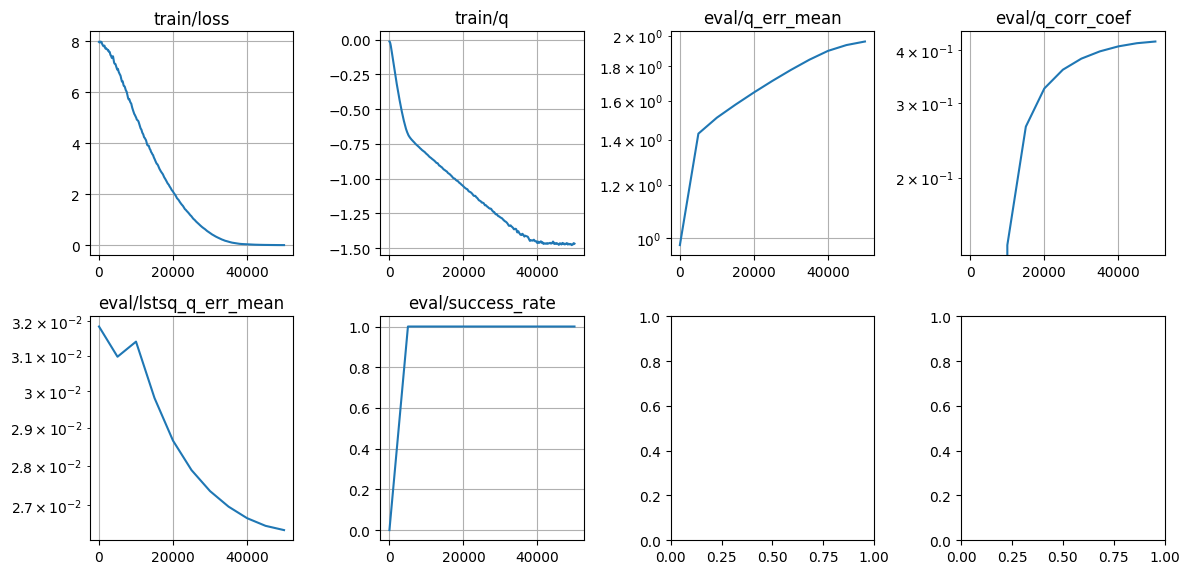

100%|██████████| 50000/50000 [00:39<00:00, 1268.66it/s]


In [65]:
batch_size = 1024
tau = 0.005
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

key = jax.random.PRNGKey(np.random.randint(0, 2**32))
key, critic_key = jax.random.split(key)

example_batch = sample_batch(2)
critic = Critic()
# critic_params = critic.init(critic_key, example_batch['observations'], example_batch['actions'])
critic_params = critic.init(critic_key, example_batch['observations'], example_batch['actions'])
target_critic_params = copy.deepcopy(critic_params)

def loss_fn(params, target_params, batch):
  q = critic.apply(params, batch['observations'], batch['actions'])
  # q = jnp.sum(qs * jax.nn.one_hot(batch['actions'], env.nA), axis=-1)
  
  next_observations = batch['next_observations'][:, None].repeat(env.nA, axis=1).reshape(-1)
  next_actions = jnp.arange(eval_env.nA)[None, :].repeat(batch_size, axis=0).reshape(-1)
  # next_qs = []
  # for idx in range(env.nA):
  #   next_q = critic.apply(target_params, batch['next_observations'], jnp.full_like(batch['next_observations'], idx))
  #   next_qs.append(next_qs)
  # next_qs = jnp.stack(next_qs, axis=-1)
  next_qs = critic.apply(target_params, next_observations, next_actions)
  next_qs = next_qs.reshape([batch_size, env.nA])
  next_q = jnp.max(next_qs, axis=-1)
  # target_q = (1 - discount ** 2) * batch['rewards'] + discount ** 2 * batch['masks'] * next_q
  target_q = (1 - discount ** 2) * batch['rewards'] + discount ** 2 * next_q
  # target_q = (1 - discount) * batch['rewards'] + discount * next_q

  loss = jnp.mean((q - target_q) ** 2)
  
  info = {
    'loss': loss,
    'q': q.mean(),
  }
  
  return loss, info

optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(critic_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, target_params, opt_state, batch):
  (loss, info), grads = grad_fn(params, target_params, batch)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  
  target_params = jax.tree_util.tree_map(
    lambda p, tp: p * tau + tp * (1 - tau),
    params, target_params,
  )
  
  return params, target_params, opt_state, loss, info

def compute_success_rate(params, num_eval_episodes=100, max_episode_steps=100):
  eval_env = CliffWalkingEnv(random_init_state=True, max_episode_steps=max_episode_steps)
  
  # compute the pi
  obs = jnp.arange(eval_env.nS)[:, None].repeat(eval_env.nA, axis=1).reshape(-1)
  actions = jnp.arange(eval_env.nA)[None, :].repeat(eval_env.nS, axis=0).reshape(-1)
  q = critic.apply(params, obs, actions)
  q = q.reshape([eval_env.nS, eval_env.nA])
  # obs = jnp.arange(eval_env.nS)
  # q = critic.apply(params, obs)
  a = jnp.argmax(q, axis=-1)
  pi = jax.nn.one_hot(a, eval_env.nA)
  pi = np.asarray(pi)

  # evaluation
  successes = []
  for _ in tqdm.trange(num_eval_episodes):
      traj_dataset = defaultdict(list)

      done = False
      obs, _ = eval_env.reset()
      while not done:
          action = np.random.choice(np.arange(eval_env.nA), p=pi[obs])
          next_obs, reward, terminated, truncated, _ = eval_env.step(action)
          done = terminated or truncated
          
          traj_dataset['observations'].append(obs)
          traj_dataset['actions'].append(action)
          traj_dataset['rewards'].append(reward)
          traj_dataset['next_observations'].append(next_obs)
          
          obs = next_obs
      successes.append(47 in traj_dataset['next_observations'])
  sr = np.mean(successes)

  return sr

def evaluate_fn(params):
  obs = jnp.arange(env.nS)[:, None].repeat(env.nA, axis=1).reshape(-1)
  actions = jnp.arange(env.nA)[None, :].repeat(env.nS, axis=0).reshape(-1)
  q = critic.apply(params, obs, actions)
  q = q.reshape([env.nS, env.nA])
  # obs = jnp.arange(env.nS)
  # q = critic.apply(params, obs)
  # scaled_q = q * (opt_q_square_discount / q).mean()
  # q_err_mean = jnp.mean(np.abs(q - opt_q_square_discount))
  # scaled_q_err_mean = jnp.mean(np.abs(scaled_q - opt_q_square_discount))
  # q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q_square_discount.reshape(-1))[0, 1]
  
  slopes, intercepts = jnp.linalg.lstsq(
    jnp.stack([q.reshape(-1), jnp.ones_like(q.reshape(-1))], axis=1), 
    opt_q_square_discount.reshape(-1)
  )[0]
  lstsq_q = slopes * q + intercepts
  
  q_err_mean = jnp.mean(np.abs(q - opt_q_square_discount))
  q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q_square_discount.reshape(-1))[0, 1]
  lstsq_q_err_mean = jnp.mean(np.abs(lstsq_q - opt_q_square_discount))
  
  sr = compute_success_rate(params)
  
  info = {
    'q_err_mean': q_err_mean,
    'q_corr_coef': q_corr_coef,
    'lstsq_q_err_mean': lstsq_q_err_mean,
    'success_rate': sr,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_batch(batch_size)
  critic_params, target_critic_params, opt_state, loss, info = update_fn(
    critic_params, target_critic_params, opt_state, batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    eval_info = evaluate_fn(critic_params)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean', 'eval/q_corr_coef', 'eval/lstsq_q_err_mean'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [58]:
obs = jnp.arange(env.nS)
# actions = jnp.arange(env.nA)[None, :].repeat(env.nS, axis=0).reshape(-1)
q = critic.apply(critic_params, obs)
q = q.reshape([env.nS, env.nA])

print(q)

print(opt_q_square_discount)

print(q[0].argmax())
print(q[11].argmax())
print(q[23].argmax())
print(q[35].argmax())

print(opt_policy[11])
print(opt_policy[23])
print(opt_policy[35])

# [0.99214639 0.99237827 0.99237827 0.99214639]
# [0.99237827 0.9926352  0.9926352  0.99214639]

[[-7.8535032e-01 -7.6215136e-01 -7.6215321e-01 -7.8532720e-01]
 [-7.6215345e-01 -7.3645324e-01 -7.3646051e-01 -7.8534198e-01]
 [-7.3645002e-01 -7.0798171e-01 -7.0798331e-01 -7.6215863e-01]
 [-7.0798224e-01 -6.7643583e-01 -6.7636466e-01 -7.3645210e-01]
 [-6.7643380e-01 -6.4148414e-01 -6.4148891e-01 -7.0797670e-01]
 [-6.4148617e-01 -6.0275710e-01 -6.0278094e-01 -6.7643601e-01]
 [-6.0275525e-01 -5.5983818e-01 -5.5987304e-01 -6.4156640e-01]
 [-5.6000501e-01 -5.1229525e-01 -5.1229781e-01 -6.0275728e-01]
 [-5.1229113e-01 -4.5960474e-01 -4.5964819e-01 -5.5984712e-01]
 [-4.5961648e-01 -4.0125731e-01 -4.0124547e-01 -5.1229686e-01]
 [-4.0125635e-01 -3.3655843e-01 -3.3656585e-01 -4.5964170e-01]
 [-3.3657154e-01 -3.3659434e-01 -2.6473480e-01 -4.0125698e-01]
 [-7.8534198e-01 -7.3646152e-01 -7.3647022e-01 -7.6215315e-01]
 [-7.6214927e-01 -7.0801425e-01 -7.0799410e-01 -7.6216817e-01]
 [-7.3645145e-01 -6.7643613e-01 -6.7644793e-01 -7.3645461e-01]
 [-7.0798099e-01 -6.4148909e-01 -6.4149344e-01 -7.07983

In [66]:
q_learning_metrics = metrics
print(q_learning_metrics['eval/q_err_mean'][-1])
print(q_learning_metrics['eval/q_corr_coef'][-1])
print(q_learning_metrics['eval/lstsq_q_err_mean'][-1])
print(q_learning_metrics['eval/success_rate'][-1])

[5.00000000e+04 1.08703598e-02]
[5.00000000e+04 9.94610667e-01]
[5.00000000e+04 1.91504112e-03]
[5.0e+04 2.6e-01]


### SGCQL

In [ ]:
class Critic(nn.Module):
  @nn.compact
  def __call__(self, obs, action):
    obs = jax.nn.one_hot(obs, augmented_env.num_states)
    action = jax.nn.one_hot(action, augmented_env.num_actions)
    inputs = jnp.concatenate([obs, action], axis=-1)
    
    qs = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(1),
    ])(inputs)
    
    qs = qs.squeeze(-1)

    return qs

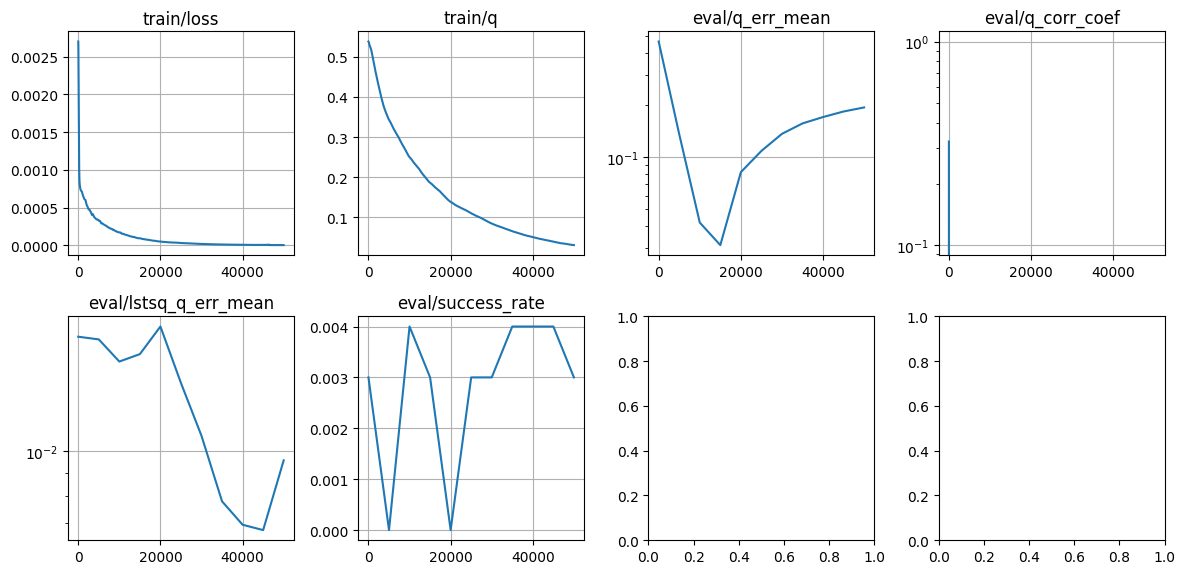

100%|██████████| 50000/50000 [02:32<00:00, 328.17it/s]


In [ ]:
batch_size = 1024
tau = 0.005
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

indicators = np.zeros((augmented_env.num_states, augmented_env.num_actions))
indicators[augmented_env.num_states - 2] = 1.
indicators = jnp.asarray(indicators)

key = jax.random.PRNGKey(np.random.randint(0, 2**32))
key, critic_key = jax.random.split(key)

example_batch = sample_augmented_batch(2)
critic = Critic()
critic_params = critic.init(critic_key, example_batch['observations'], example_batch['actions'])
target_critic_params = copy.deepcopy(critic_params)

def loss_fn(params, target_params, batch):
  q = critic.apply(params, batch['observations'], batch['actions'])
  
  next_q1 = critic.apply(target_params, batch['next_observations'], jnp.zeros_like(batch['next_observations']))
  next_q2 = critic.apply(target_params, batch['next_observations'], jnp.ones_like(batch['next_observations']))
  next_q = jnp.maximum(next_q1, next_q2)
  target_q = (1 - discount) * batch['rewards'] + discount * batch['masks'] * next_q

  loss = jnp.mean((q - target_q) ** 2)
  
  scaled_q = q * discount + indicators[batch['observations'], batch['actions']] * (1 - discount)
  scaled_q = scaled_q * (1 + discount) / discount
  
  info = {
    'loss': loss,
    'q': scaled_q.mean(),
  }
  
  return loss, info

optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(critic_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, target_params, opt_state, batch):
  (loss, info), grads = grad_fn(params, target_params, batch)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  
  target_params = jax.tree_util.tree_map(
    lambda p, tp: p * tau + tp * (1 - tau),
    params, target_params,
  )
  
  return params, target_params, opt_state, loss, info

def compute_success_rate(params, num_eval_episodes=2000, max_episode_steps=1001):
  seed = 100
  augmented_eval_env = AugmentedRiverSwim(discount=discount, seed=seed, max_episode_steps=max_episode_steps)
  
  # compute the pi
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  q = critic.apply(params, obs, actions)
  q = q.reshape([augmented_env.num_states, augmented_env.num_actions])
  a = jnp.argmax(q, axis=-1)
  pi = jax.nn.one_hot(a, augmented_env.num_actions)
  pi = np.asarray(pi)

  # evaluation
  successes = []
  for _ in tqdm.trange(num_eval_episodes):
    traj_dataset = defaultdict(list)

    done = False
    obs = augmented_eval_env.reset()
    while not done:
      action = np.random.choice(np.arange(augmented_eval_env.num_actions), p=pi[obs])
      reward, next_obs, terminated, truncated = augmented_eval_env.step(action)
      done = terminated or truncated
      
      traj_dataset['observations'].append(obs)
      traj_dataset['actions'].append(action)
      traj_dataset['rewards'].append(reward)
      
      obs = next_obs
    successes.append(np.sum(traj_dataset['rewards']) >= 1.0)

  sr = np.mean(successes)

  return sr

def evaluate_fn(params):
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  gc_q = critic.apply(params, obs, actions)
  gc_q = gc_q.reshape([augmented_env.num_states, augmented_env.num_actions])
  # q = gc_q[:env.num_states]
  # q = q * (1 + discount) / discount
  scaled_gc_q = gc_q * discount + indicators * (1 - discount)
  scaled_gc_q = scaled_gc_q * (1 + discount) / discount
  q = scaled_gc_q[:env.num_states]
  
  slopes, intercepts = jnp.linalg.lstsq(
    jnp.stack([q.reshape(-1), jnp.ones_like(q.reshape(-1))], axis=1), 
    opt_q_square_discount.reshape(-1)
  )[0]
  lstsq_q = slopes * q + intercepts
  
  q_err_mean = jnp.mean(np.abs(q - opt_q_square_discount))
  q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q_square_discount.reshape(-1))[0, 1]
  lstsq_q_err_mean = jnp.mean(np.abs(lstsq_q - opt_q_square_discount))
  
  sr = compute_success_rate(params)
  
  info = {
    'q_err_mean': q_err_mean,
    'q_corr_coef': q_corr_coef,
    'lstsq_q_err_mean': lstsq_q_err_mean,
    'success_rate': sr,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_augmented_batch(batch_size)
  critic_params, target_critic_params, opt_state, loss, info = update_fn(
    critic_params, target_critic_params, opt_state, batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    eval_info = evaluate_fn(critic_params)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean', 'eval/q_corr_coef', 'eval/lstsq_q_err_mean'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [ ]:
sgcql_metrics = metrics
print(sgcql_metrics['eval/q_err_mean'][-1])
print(sgcql_metrics['eval/q_corr_coef'][-1])
print(sgcql_metrics['eval/lstsq_q_err_mean'][-1])
print(sgcql_metrics['eval/success_rate'][-1])

[5.0000000e+04 1.9415383e-01]
[ 5.0000000e+04 -8.4401983e-01]
[5.00000000e+04 9.56703164e-03]
[5.e+04 3.e-03]


In [ ]:
# evaluation the pi
obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
gc_q = critic.apply(critic_params, obs, actions)
gc_q = gc_q.reshape([augmented_env.num_states, augmented_env.num_actions])
gc_a = jnp.argmax(gc_q, axis=-1)
pi = jax.nn.one_hot(gc_a, augmented_env.num_actions)
pi = np.asarray(pi)

print("pi: ")
print(pi)


pi: 
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


### GCQL + HER

In [ ]:
class Critic(nn.Module):
  @nn.compact
  def __call__(self, obs, action, goals):
    obs = jax.nn.one_hot(obs, augmented_env.num_states)
    action = jax.nn.one_hot(action, augmented_env.num_actions)
    goals = jax.nn.one_hot(goals, augmented_env.num_states)
    inputs = jnp.concatenate([obs, action, goals], axis=-1)

    qs = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(1),
    ])(inputs)
    
    qs = qs.squeeze(-1)

    return qs

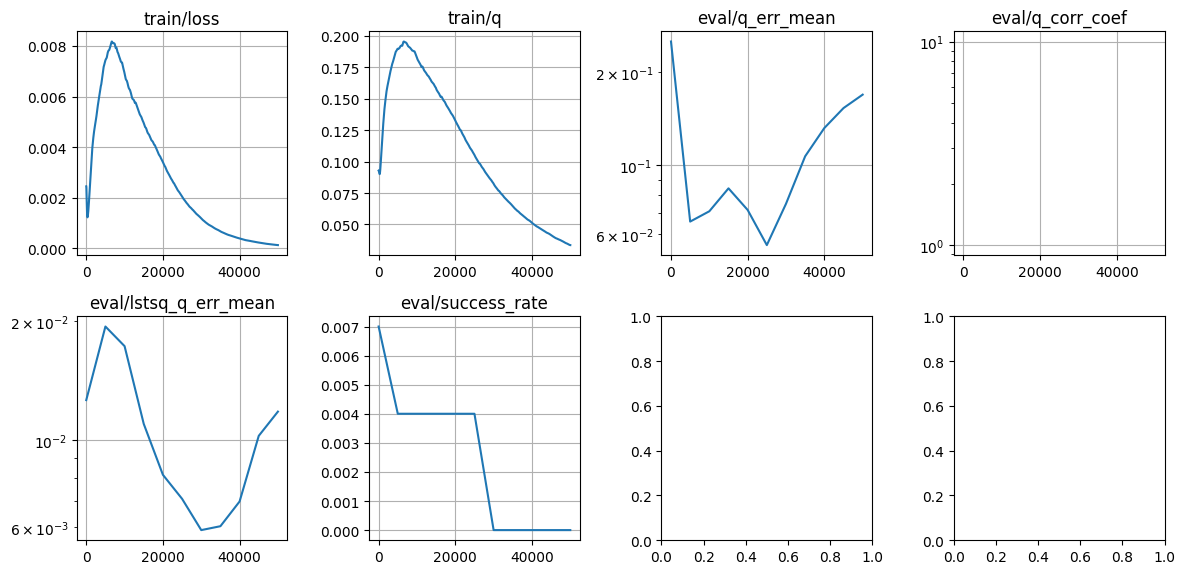

100%|██████████| 50000/50000 [02:36<00:00, 320.19it/s]


In [ ]:
batch_size = 1024
tau = 0.005
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

indicators = np.zeros((augmented_env.num_states, augmented_env.num_actions))
indicators[augmented_env.num_states - 2] = 1.
indicators = jnp.asarray(indicators)

key = jax.random.PRNGKey(np.random.randint(0, 2**32))
key, critic_key = jax.random.split(key)

example_batch = sample_augmented_batch(2, relabel_reward=True)
critic = Critic()
critic_params = critic.init(critic_key, 
                            example_batch['observations'], 
                            example_batch['actions'], 
                            example_batch['goals'])
target_critic_params = copy.deepcopy(critic_params)

def loss_fn(params, target_params, batch):
  q = critic.apply(params, batch['observations'], batch['actions'], batch['goals'])
  
  next_q1 = critic.apply(target_params, batch['next_observations'], jnp.zeros_like(batch['next_observations']), batch['goals'])
  next_q2 = critic.apply(target_params, batch['next_observations'], jnp.ones_like(batch['next_observations']), batch['goals'])
  next_q = jnp.maximum(next_q1, next_q2)
  target_q = (1 - discount) * batch['rewards'] + discount * batch['masks'] * next_q

  loss = jnp.mean((q - target_q) ** 2)

  # for logging
  gc_q = critic.apply(params, batch['observations'], batch['actions'], (augmented_env.num_states - 2) * jnp.ones_like(batch['goals']))  
  scaled_gc_q = gc_q * discount + indicators[batch['observations'], batch['actions']] * (1 - discount)
  scaled_gc_q = scaled_gc_q * (1 + discount) / discount
  
  info = {
    'loss': loss,
    'q': q.mean(),
  }
  
  return loss, info

optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(critic_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, target_params, opt_state, batch):
  (loss, info), grads = grad_fn(params, target_params, batch)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  
  target_params = jax.tree_util.tree_map(
    lambda p, tp: p * tau + tp * (1 - tau),
    params, target_params,
  )
  
  return params, target_params, opt_state, loss, info

def compute_success_rate(params, num_eval_episodes=2000, max_episode_steps=1001):
  seed = 100
  augmented_eval_env = AugmentedRiverSwim(discount=discount, seed=seed, max_episode_steps=max_episode_steps)
  
  # compute the pi
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  q = critic.apply(params, obs, actions, (augmented_env.num_states - 2) * jnp.ones_like(obs))
  q = q.reshape([augmented_env.num_states, augmented_env.num_actions])
  a = jnp.argmax(q, axis=-1)
  pi = jax.nn.one_hot(a, augmented_env.num_actions)
  pi = np.asarray(pi)

  # evaluation
  successes = []
  for _ in tqdm.trange(num_eval_episodes):
    traj_dataset = defaultdict(list)

    done = False
    obs = augmented_eval_env.reset()
    while not done:
      action = np.random.choice(np.arange(augmented_eval_env.num_actions), p=pi[obs])
      reward, next_obs, terminated, truncated = augmented_eval_env.step(action)
      done = terminated or truncated
      
      traj_dataset['observations'].append(obs)
      traj_dataset['actions'].append(action)
      traj_dataset['rewards'].append(reward)
      
      obs = next_obs
    successes.append(np.sum(traj_dataset['rewards']) >= 1.0)

  sr = np.mean(successes)

  return sr

def evaluate_fn(params):
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  gc_q = critic.apply(params, obs, actions, (augmented_env.num_states - 2) * jnp.ones_like(obs))
  gc_q = gc_q.reshape([augmented_env.num_states, augmented_env.num_actions])
  # q = gc_q[:env.num_states]
  # q = q * (1 + discount) / discount
  scaled_gc_q = gc_q * discount + indicators * (1 - discount)
  scaled_gc_q = scaled_gc_q * (1 + discount) / discount
  q = scaled_gc_q[:env.num_states]
  
  slopes, intercepts = jnp.linalg.lstsq(
    jnp.stack([q.reshape(-1), jnp.ones_like(q.reshape(-1))], axis=1), 
    opt_q_square_discount.reshape(-1)
  )[0]
  lstsq_q = slopes * q + intercepts
  
  q_err_mean = jnp.mean(np.abs(q - opt_q_square_discount))
  q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q_square_discount.reshape(-1))[0, 1]
  lstsq_q_err_mean = jnp.mean(np.abs(lstsq_q - opt_q_square_discount))
  
  sr = compute_success_rate(params)
  
  info = {
    'q_err_mean': q_err_mean,
    'q_corr_coef': q_corr_coef,
    'lstsq_q_err_mean': lstsq_q_err_mean,
    'success_rate': sr,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_augmented_batch(batch_size, relabel_reward=True)
  critic_params, target_critic_params, opt_state, loss, info = update_fn(
    critic_params, target_critic_params, opt_state, batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    eval_info = evaluate_fn(critic_params)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean', 'eval/q_corr_coef', 'eval/lstsq_q_err_mean'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [ ]:
gcql_her_metrics = metrics
print(gcql_her_metrics['eval/q_err_mean'][-1])
print(gcql_her_metrics['eval/q_corr_coef'][-1])
print(gcql_her_metrics['eval/lstsq_q_err_mean'][-1])
print(gcql_her_metrics['eval/success_rate'][-1])

[5.000000e+04 1.690301e-01]
[ 5.00000000e+04 -7.98020065e-01]
[5.00000000e+04 1.17807575e-02]
[50000.     0.]


In [ ]:
# evaluation the pi
obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
q = critic.apply(critic_params, obs, actions, (augmented_env.num_states - 2) * jnp.ones_like(obs))
q = q.reshape([augmented_env.num_states, augmented_env.num_actions])
a = jnp.argmax(q, axis=-1)
pi = jax.nn.one_hot(a, augmented_env.num_actions)
pi = np.asarray(pi)

print("pi: ")
print(pi)

pi: 
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


### CRL + Binary NCE

In [ ]:
large_batch = sample_augmented_batch(1_000_000, p_curgoal=0.0, p_trajgoal=1.0)

goal_marg = np.zeros(augmented_env.num_states)
for state in range(augmented_env.num_states):
    # goal_marg[state] = np.sum(large_batch['next_observations'] == state) / len(large_batch['next_observations'])
    goal_marg[state] = np.sum(large_batch['next_observations'] == state) / len(large_batch['next_observations'])
goal_marg = jnp.asarray(goal_marg)
print(goal_marg)


[0.006106 0.024537 0.05632  0.140205 0.434463 0.328242 0.001932 0.008195]


In [ ]:
class Critic(nn.Module):
  repr_dim: int = 512

  @nn.compact
  def __call__(self, obs, action, future_obs):
    obs = jax.nn.one_hot(obs, augmented_env.num_states)
    action = jax.nn.one_hot(action, augmented_env.num_actions)
    future_obs = jax.nn.one_hot(future_obs, augmented_env.num_states)
    phi_inputs = jnp.concatenate([obs, action], axis=-1)
    psi_inputs = future_obs

    phi = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(self.repr_dim),
    ])(phi_inputs)
    psi = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(self.repr_dim),
    ])(psi_inputs)
    
    logits = jnp.einsum('ik,jk->ij', phi, psi)
    logits = logits / jnp.sqrt(self.repr_dim)
    
    return logits

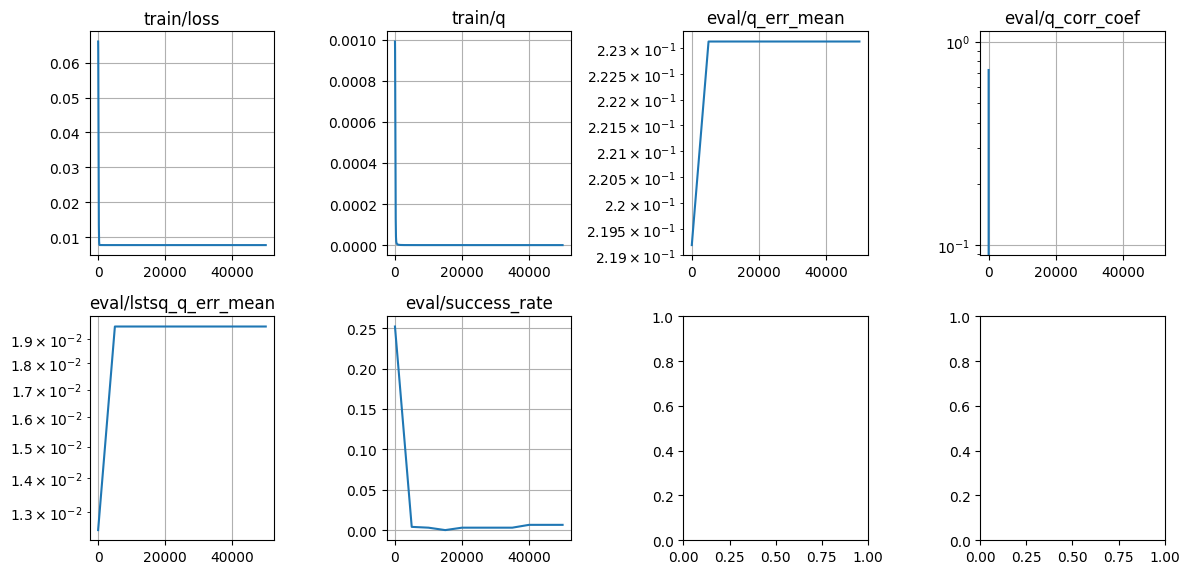

100%|██████████| 50000/50000 [03:27<00:00, 241.06it/s]


In [ ]:
batch_size = 1024
tau = 0.005
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

key = jax.random.PRNGKey(np.random.randint(0, 2**32))
key, critic_key = jax.random.split(key)

example_batch = sample_augmented_batch(2, p_curgoal=0.0, p_trajgoal=1.0)
critic = Critic(repr_dim=32)
critic_params = critic.init(critic_key, example_batch['observations'], example_batch['actions'], example_batch['next_observations'])

def loss_fn(params, batch):
  pos_logits = critic.apply(
    params, batch['observations'], batch['actions'], batch['goals'])
  neg_logits = critic.apply(
    params, batch['observations'], batch['actions'], batch['next_observations'])
  
  I = jnp.eye(batch_size)
  logits = I * pos_logits + (1 - I) * neg_logits
  loss = optax.sigmoid_binary_cross_entropy(logits=logits, labels=I).mean()
  
  plus_logits = critic.apply(params, batch['observations'], batch['actions'], 
                             (augmented_env.num_states - 2) * jnp.ones_like(batch['observations']))
  plus_probs = jnp.exp(jnp.diag(plus_logits)) * goal_marg[augmented_env.num_states - 2]
  q = (1 + discount) / discount * plus_probs
  
  info = {
    'loss': loss,
    'q': q.mean(),
  }
  
  return loss, info

optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(critic_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, opt_state, batch):
  (loss, info), grads = grad_fn(params, batch)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  
  return params, opt_state, loss, info

def compute_success_rate(params, num_eval_episodes=2000, max_episode_steps=1001):
  seed = 100
  augmented_eval_env = AugmentedRiverSwim(discount=discount, seed=seed, max_episode_steps=max_episode_steps)
  
  # compute the pi
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  plus_logits = critic.apply(params, obs, actions, 
                             (augmented_env.num_states - 2) * jnp.ones_like(obs))
  plus_logits = jnp.diag(plus_logits)
  plus_logits = plus_logits.reshape([augmented_env.num_states, augmented_env.num_actions])
  a = jnp.argmax(plus_logits, axis=-1)
  pi = jax.nn.one_hot(a, augmented_env.num_actions)
  pi = np.asarray(pi)
  
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  plus_logits = critic.apply(critic_params, obs, actions, 
                            (augmented_env.num_states - 2) * jnp.ones_like(obs))
  plus_probs = jnp.exp(jnp.diag(plus_logits)) * goal_marg[augmented_env.num_states - 2]
  q = (1 + discount) / discount * plus_probs
  q = q.reshape([augmented_env.num_states, augmented_env.num_actions])
  q = q[:env.num_states]

  # evaluation
  successes = []
  for _ in tqdm.trange(num_eval_episodes):
    traj_dataset = defaultdict(list)

    done = False
    obs = augmented_eval_env.reset()
    while not done:
      action = np.random.choice(np.arange(augmented_eval_env.num_actions), p=pi[obs])
      reward, next_obs, terminated, truncated = augmented_eval_env.step(action)
      done = terminated or truncated
      
      traj_dataset['observations'].append(obs)
      traj_dataset['actions'].append(action)
      traj_dataset['rewards'].append(reward)
      
      obs = next_obs
    successes.append(np.sum(traj_dataset['rewards']) >= 1.0)

  sr = np.mean(successes)

  return sr

def evaluate_fn(params):
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  plus_logits = critic.apply(params, obs, actions, 
                             (augmented_env.num_states - 2) * jnp.ones_like(obs))
  plus_probs = jnp.exp(jnp.diag(plus_logits)) * goal_marg[augmented_env.num_states - 2]
  q = (1 + discount) / discount * plus_probs
  q = q.reshape([augmented_env.num_states, augmented_env.num_actions])
  q = q[:env.num_states]
  
  slopes, intercepts = jnp.linalg.lstsq(
    jnp.stack([q.reshape(-1), jnp.ones_like(q.reshape(-1))], axis=1), 
    opt_q_square_discount.reshape(-1)
  )[0]
  lstsq_q = slopes * q + intercepts
  
  q_err_mean = jnp.mean(np.abs(q - opt_q_square_discount))
  q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q_square_discount.reshape(-1))[0, 1]
  lstsq_q_err_mean = jnp.mean(np.abs(lstsq_q - opt_q_square_discount))
  
  sr = compute_success_rate(params)
  # scaled_q = q * (opt_q_square_discount / q).mean()
  # q_err_mean = jnp.mean(jnp.abs(q - opt_q_square_discount))
  # scaled_q_err_mean = jnp.mean(jnp.abs(scaled_q - opt_q_square_discount))
  # q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q_square_discount.reshape(-1))[0, 1]
  
  # random_states = jnp.roll(batch['next_observations'], -1, axis=0)
  # logits = critic.apply(params, batch['observations'], batch['actions'], random_states)
  # ratios = jax.nn.softmax(logits, axis=-1) * batch_size
  # probs = jnp.diag(ratios) * s_marg[random_states]
  # prob_err_mean = jnp.mean(jnp.abs(probs - opt_d_sa[batch['observations'], batch['actions'], random_states]))
  
  info = {
    'q_err_mean': q_err_mean,
    'q_corr_coef': q_corr_coef,
    'lstsq_q_err_mean': lstsq_q_err_mean,
    'success_rate': sr,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_augmented_batch(batch_size, p_curgoal=0.0, p_trajgoal=1.0)
  critic_params, opt_state, loss, info = update_fn(
    critic_params, opt_state, batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    eval_info = evaluate_fn(critic_params)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean', 'eval/lstsq_q_err_mean', 'eval/q_corr_coef'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [ ]:
crl_metrics = metrics
print(crl_metrics['eval/q_err_mean'][-1])
print(crl_metrics['eval/q_corr_coef'][-1])
print(crl_metrics['eval/lstsq_q_err_mean'][-1])
print(crl_metrics['eval/success_rate'][-1])

[5.00000000e+04 2.23133415e-01]
[ 5.00000000e+04 -1.28275454e-01]
[5.00000000e+04 1.95168965e-02]
[5.0e+04 6.5e-03]


In [ ]:
# evaluation the pi
obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)

plus_logits = critic.apply(critic_params, obs, actions, 
                           (augmented_env.num_states - 2) * jnp.ones_like(obs))
plus_logits = jnp.diag(plus_logits)
plus_logits = plus_logits.reshape([augmented_env.num_states, augmented_env.num_actions])
a = jnp.argmax(plus_logits, axis=-1)
pi = jax.nn.one_hot(a, augmented_env.num_actions)
pi = np.asarray(pi)

print("pi: ")
print(pi)

pi: 
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


### SGC TD InfoNCE

In [ ]:
s_marg = np.zeros(augmented_env.num_states)
for state in range(augmented_env.num_states):
    s_marg[state] = np.sum(augmented_train_dataset['next_observations'] == state) / len(augmented_train_dataset['next_observations'])
s_marg = jnp.asarray(s_marg)
print(s_marg)

[0.00611486 0.02486911 0.05628272 0.14004236 0.43419528 0.32839414
 0.00189841 0.00820311]


In [ ]:
class Critic(nn.Module):
  repr_dim: int = 512

  @nn.compact
  def __call__(self, obs, action, future_obs):
    obs = jax.nn.one_hot(obs, augmented_env.num_states)
    action = jax.nn.one_hot(action, augmented_env.num_actions)
    future_obs = jax.nn.one_hot(future_obs, augmented_env.num_states)
    phi_inputs = jnp.concatenate([obs, action], axis=-1)
    psi_inputs = future_obs

    phi = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(self.repr_dim),
    ])(phi_inputs)
    psi = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(self.repr_dim),
    ])(psi_inputs)
    
    logits = jnp.einsum('ik,jk->ij', phi, psi)
    logits = logits / jnp.sqrt(self.repr_dim)
    
    return logits

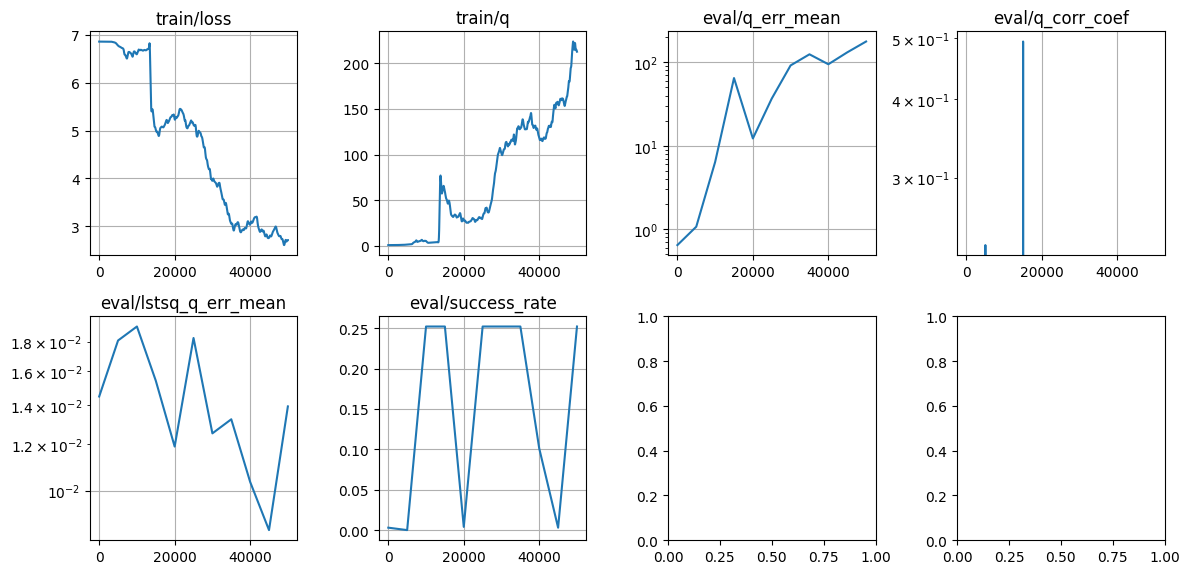

100%|██████████| 50000/50000 [03:43<00:00, 223.70it/s]


In [ ]:
batch_size = 1024
tau = 0.005
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

indicators = np.zeros((augmented_env.num_states, augmented_env.num_actions))
indicators[augmented_env.num_states - 2] = 1.
indicators = jnp.asarray(indicators)
s_plus_marg = jnp.sum(augmented_train_dataset['next_observations'] == env.num_states - 2) / len(augmented_train_dataset['next_observations'])

key = jax.random.PRNGKey(np.random.randint(0, 2**32))
key, critic_key = jax.random.split(key)

example_batch = sample_augmented_batch(2)
critic = Critic(repr_dim=32)
critic_params = critic.init(critic_key, example_batch['observations'], example_batch['actions'], example_batch['next_observations'])
target_critic_params = copy.deepcopy(critic_params)

def loss_fn(params, target_params, batch):
  logits = critic.apply(
    params, batch['observations'], batch['actions'], batch['next_observations'])
  
  random_states = jnp.roll(batch['next_observations'], -1, axis=0)
  random_logits = critic.apply(
    params, batch['observations'], batch['actions'], random_states)
  
  I = jnp.eye(batch_size)
  logits = I * logits + (1 - I) * random_logits
  cur_loss = optax.softmax_cross_entropy(logits=logits, labels=I)
  
  future_logit1 = critic.apply(
    target_params, batch['next_observations'], jnp.zeros_like(batch['next_observations']), random_states)
  future_logit2 = critic.apply(
    target_params, batch['next_observations'], jnp.ones_like(batch['next_observations']), random_states)
  plus_logits1 = critic.apply(target_params, batch['next_observations'], jnp.zeros_like(batch['next_observations']), 
                              (augmented_env.num_states - 2) * jnp.ones_like(batch['observations']))
  plus_logits2 = critic.apply(target_params, batch['next_observations'], jnp.ones_like(batch['next_observations']), 
                              (augmented_env.num_states - 2) * jnp.ones_like(batch['observations']))
  plus_log_probs1 = jnp.diag(plus_logits1) - jax.nn.logsumexp(future_logit1, axis=-1)
  plus_log_probs2 = jnp.diag(plus_logits2) - jax.nn.logsumexp(future_logit2, axis=-1)
  plus_log_probs = jnp.stack([plus_log_probs1, plus_log_probs2], axis=-1)
  next_actions = jnp.argmax(plus_log_probs, axis=-1)
  next_actions = jax.lax.stop_gradient(next_actions)
  
  w_logits = critic.apply(
    target_params, batch['next_observations'], next_actions, random_states)
  w = jax.nn.softmax(w_logits, axis=-1)
  w = jax.lax.stop_gradient(w) * batch_size * I
  # w = jnp.clip(w, 0.0, 100.0 / batch_size)
  
  future_loss = optax.softmax_cross_entropy(logits=random_logits, labels=w)
  
  loss = (1 - discount) * cur_loss + discount * batch['masks'] * future_loss
  loss = jnp.mean(loss)
  
  plus_logits = critic.apply(params, batch['observations'], batch['actions'], 
                             (augmented_env.num_states - 2) * jnp.ones_like(batch['observations']))
  plus_log_probs = jnp.diag(plus_logits) - jax.nn.logsumexp(random_logits, axis=-1)
  probs = jnp.exp(plus_log_probs) * batch_size * s_plus_marg
  scaled_probs = discount * probs + (1 - discount) * indicators[batch['observations'], batch['actions']]
  q = scaled_probs * (1 + discount) / discount
  
  info = {
    'loss': loss,
    'q': q.mean(),
  }
  
  return loss, info

optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(critic_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, target_params, opt_state, batch):
  (loss, info), grads = grad_fn(params, target_params, batch)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  
  target_params = jax.tree_util.tree_map(
    lambda p, tp: p * tau + tp * (1 - tau),
    params, target_params,
  )
  
  return params, target_params, opt_state, loss, info

def compute_success_rate(params, batch, num_eval_episodes=2000, max_episode_steps=1001):
  seed = 100
  augmented_eval_env = AugmentedRiverSwim(discount=discount, seed=seed, max_episode_steps=max_episode_steps)
  
  # compute the pi
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  # plus_logits = critic.apply(params, obs, actions, 
  #                            (augmented_env.num_states - 2) * jnp.ones_like(obs))
  # plus_logits = jnp.diag(plus_logits)
  # plus_logits = plus_logits.reshape([augmented_env.num_states, augmented_env.num_actions])
  random_states = jnp.roll(batch['next_observations'], -1, axis=0)
  plus_logits = critic.apply(params, obs, actions, 
                             (augmented_env.num_states - 2) * jnp.ones_like(random_states))
  random_logits = critic.apply(params, obs, actions, random_states)
  plus_log_probs = jnp.diag(plus_logits) - jax.nn.logsumexp(random_logits, axis=-1)
  plus_log_probs = plus_log_probs.reshape([augmented_env.num_states, augmented_env.num_actions])
  
  a = jnp.argmax(plus_log_probs, axis=-1)
  pi = jax.nn.one_hot(a, augmented_env.num_actions)
  pi = np.asarray(pi)
  
  # evaluation
  successes = []
  for _ in tqdm.trange(num_eval_episodes):
    traj_dataset = defaultdict(list)

    done = False
    obs = augmented_eval_env.reset()
    while not done:
      action = np.random.choice(np.arange(augmented_eval_env.num_actions), p=pi[obs])
      reward, next_obs, terminated, truncated = augmented_eval_env.step(action)
      done = terminated or truncated
      
      traj_dataset['observations'].append(obs)
      traj_dataset['actions'].append(action)
      traj_dataset['rewards'].append(reward)
      
      obs = next_obs
    successes.append(np.sum(traj_dataset['rewards']) >= 1.0)

  sr = np.mean(successes)

  return sr

def evaluate_fn(params, batch):
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  random_states = jnp.roll(batch['next_observations'], -1, axis=0)
  plus_logits = critic.apply(params, obs, actions, 
                             (augmented_env.num_states - 2) * jnp.ones_like(random_states))
  random_logits = critic.apply(params, obs, actions, random_states)
  plus_log_probs = jnp.diag(plus_logits) - jax.nn.logsumexp(random_logits, axis=-1)
  plus_probs = jnp.exp(plus_log_probs) * batch_size * s_plus_marg
  plus_probs = plus_probs.reshape([augmented_env.num_states, augmented_env.num_actions])
  scaled_plus_probs = discount * plus_probs + (1 - discount) * indicators
  q = scaled_plus_probs * (1 + discount) / discount
  q = q[:env.num_states]
  
  slopes, intercepts = jnp.linalg.lstsq(
    jnp.stack([q.reshape(-1), jnp.ones_like(q.reshape(-1))], axis=1), 
    opt_q_square_discount.reshape(-1)
  )[0]
  lstsq_q = slopes * q + intercepts
  
  q_err_mean = jnp.mean(np.abs(q - opt_q_square_discount))
  q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q_square_discount.reshape(-1))[0, 1]
  lstsq_q_err_mean = jnp.mean(np.abs(lstsq_q - opt_q_square_discount))
  
  sr = compute_success_rate(params, batch)
  
  # random_states = jnp.roll(batch['next_observations'], -1, axis=0)
  # logits = critic.apply(params, batch['observations'], batch['actions'], random_states)
  # ratios = jax.nn.softmax(logits, axis=-1) * batch_size
  # probs = jnp.diag(ratios) * s_marg[random_states]
  # prob_err_mean = jnp.mean(jnp.abs(probs - opt_d_sa[batch['observations'], batch['actions'], random_states]))
  
  info = {
    'q_err_mean': q_err_mean,
    'q_corr_coef': q_corr_coef,
    'lstsq_q_err_mean': lstsq_q_err_mean,
    'success_rate': sr,
    # 'prob_err_mean': prob_err_mean,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_augmented_batch(batch_size)
  critic_params, target_critic_params, opt_state, loss, info = update_fn(
    critic_params, target_critic_params, opt_state, batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    eval_info = evaluate_fn(critic_params, batch)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean', 'eval/lstsq_q_err_mean', 'eval/q_corr_coef'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [ ]:
sgc_td_infonce_metrics = metrics
print(sgc_td_infonce_metrics['eval/q_err_mean'][-1])
print(sgc_td_infonce_metrics['eval/q_corr_coef'][-1])
print(sgc_td_infonce_metrics['eval/lstsq_q_err_mean'][-1])
print(sgc_td_infonce_metrics['eval/success_rate'][-1])

[5.00000000e+04 5.03382802e-01]
[5.00000000e+04 9.86773908e-01]
[5.00000000e+04 3.15719983e-03]
[5.00e+04 2.52e-01]


In [ ]:
# evaluation the pi
batch = sample_augmented_batch(batch_size)

obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
random_states = jnp.roll(batch['observations'], -1, axis=0)
plus_logits = critic.apply(critic_params, obs, actions, 
                            (augmented_env.num_states - 2) * jnp.ones_like(random_states))
random_logits = critic.apply(critic_params, obs, actions, random_states)
plus_log_probs = jnp.diag(plus_logits) - jax.nn.logsumexp(random_logits, axis=-1)
plus_log_probs = plus_log_probs.reshape([augmented_env.num_states, augmented_env.num_actions])

a = jnp.argmax(plus_log_probs, axis=-1)
pi = jax.nn.one_hot(a, augmented_env.num_actions)
pi = np.asarray(pi)

print("pi: ")
print(pi)

### GC TD InfoNCE

In [ ]:
class Critic(nn.Module):
  repr_dim: int = 512

  @nn.compact
  def __call__(self, obs, action, goals, future_obs):
    obs = jax.nn.one_hot(obs, augmented_env.num_states)
    action = jax.nn.one_hot(action, augmented_env.num_actions)
    goals = jax.nn.one_hot(goals, augmented_env.num_states)
    future_obs = jax.nn.one_hot(future_obs, augmented_env.num_states)
    phi_inputs = jnp.concatenate([obs, action, goals], axis=-1)
    psi_inputs = future_obs

    phi = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(self.repr_dim),
    ])(phi_inputs)
    psi = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(self.repr_dim),
    ])(psi_inputs)
    
    logits = jnp.einsum('ik,jk->ij', phi, psi)
    logits = logits / jnp.sqrt(self.repr_dim)
    
    return logits

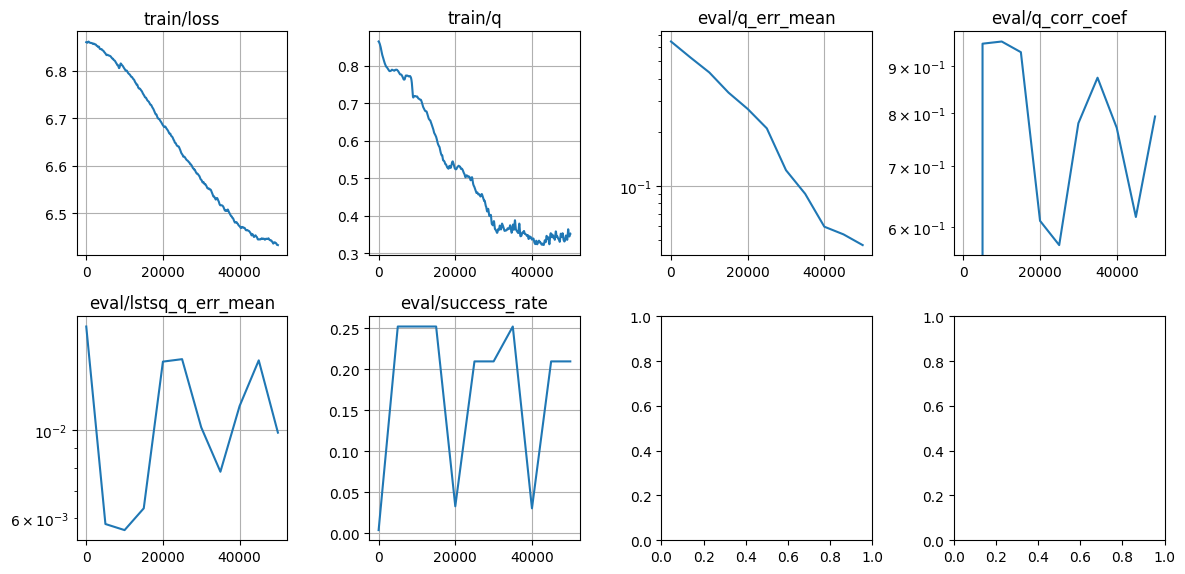

100%|██████████| 50000/50000 [03:43<00:00, 223.63it/s]


In [ ]:
batch_size = 1024
tau = 0.005
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

indicators = np.zeros((augmented_env.num_states, augmented_env.num_actions))
indicators[augmented_env.num_states - 2] = 1.
indicators = jnp.asarray(indicators)
s_plus_marg = jnp.sum(augmented_train_dataset['next_observations'] == env.num_states - 2) / len(augmented_train_dataset['next_observations'])

key = jax.random.PRNGKey(np.random.randint(0, 2**32))
key, critic_key = jax.random.split(key)

example_batch = sample_augmented_batch(2)
critic = Critic(repr_dim=16)
critic_params = critic.init(critic_key, 
                            example_batch['observations'], example_batch['actions'], 
                            example_batch['goals'], example_batch['next_observations'])
target_critic_params = copy.deepcopy(critic_params)

def loss_fn(params, target_params, batch):
  logits = critic.apply(
    params, batch['observations'], batch['actions'], batch['goals'], batch['next_observations'])
  
  random_states = jnp.roll(batch['next_observations'], -1, axis=0)
  random_logits = critic.apply(
    params, batch['observations'], batch['actions'], batch['goals'], random_states)
  
  I = jnp.eye(batch_size)
  logits = I * logits + (1 - I) * random_logits
  cur_loss = optax.softmax_cross_entropy(logits=logits, labels=I)
  
  future_logit1 = critic.apply(
    target_params, batch['next_observations'], jnp.zeros_like(batch['next_observations']), batch['goals'], random_states)
  future_logit2 = critic.apply(
    target_params, batch['next_observations'], jnp.ones_like(batch['next_observations']), batch['goals'], random_states)
  plus_logits1 = critic.apply(target_params, batch['next_observations'], jnp.zeros_like(batch['next_observations']), 
                              batch['goals'], batch['goals'])
  plus_logits2 = critic.apply(target_params, batch['next_observations'], jnp.ones_like(batch['next_observations']), 
                              batch['goals'], batch['goals'])
  plus_log_probs1 = jnp.diag(plus_logits1) - jax.nn.logsumexp(future_logit1, axis=-1)
  plus_log_probs2 = jnp.diag(plus_logits2) - jax.nn.logsumexp(future_logit2, axis=-1)
  plus_log_probs = jnp.stack([plus_log_probs1, plus_log_probs2], axis=-1)
  next_actions = jnp.argmax(plus_log_probs, axis=-1)
  next_actions = jax.lax.stop_gradient(next_actions)
  
  w_logits = critic.apply(
    target_params, batch['next_observations'], next_actions, batch['goals'], random_states)
  w = jax.nn.softmax(w_logits, axis=-1)
  w = jax.lax.stop_gradient(w)
  # w = jnp.clip(w, 0.0, 100.0 / batch_size)
  
  future_loss = optax.softmax_cross_entropy(logits=random_logits, labels=w)
  
  loss = (1 - discount) * cur_loss + discount * batch['masks'] * future_loss
  loss = jnp.mean(loss)
  
  plus_logits = critic.apply(params, batch['observations'], batch['actions'], 
                             (augmented_env.num_states - 2) * jnp.ones_like(batch['observations']),
                             (augmented_env.num_states - 2) * jnp.ones_like(batch['observations']))
  random_logits = critic.apply(params, batch['observations'], batch['actions'],
                               (augmented_env.num_states - 2) * jnp.ones_like(batch['observations']),
                               random_states)
  plus_log_probs = jnp.diag(plus_logits) - jax.nn.logsumexp(random_logits, axis=-1)
  probs = jnp.exp(plus_log_probs) * batch_size * s_plus_marg
  scaled_probs = discount * probs + (1 - discount) * indicators[batch['observations'], batch['actions']]
  q = scaled_probs * (1 + discount) / discount
  
  info = {
    'loss': loss,
    'q': q.mean(),
  }
  
  return loss, info

optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(critic_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, target_params, opt_state, batch):
  (loss, info), grads = grad_fn(params, target_params, batch)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  
  target_params = jax.tree_util.tree_map(
    lambda p, tp: p * tau + tp * (1 - tau),
    params, target_params,
  )
  
  return params, target_params, opt_state, loss, info

def compute_success_rate(params, batch, num_eval_episodes=2000, max_episode_steps=1001):
  seed = 100
  augmented_eval_env = AugmentedRiverSwim(discount=discount, seed=seed, max_episode_steps=max_episode_steps)
  
  # compute the pi
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  # plus_logits = critic.apply(params, obs, actions, 
  #                            (augmented_env.num_states - 2) * jnp.ones_like(obs))
  # plus_logits = jnp.diag(plus_logits)
  # plus_logits = plus_logits.reshape([augmented_env.num_states, augmented_env.num_actions])
  random_states = jnp.roll(batch['next_observations'], -1, axis=0)
  plus_logits = critic.apply(params, obs, actions, 
                             (augmented_env.num_states - 2) * jnp.ones_like(obs),
                             (augmented_env.num_states - 2) * jnp.ones_like(obs))
  random_logits = critic.apply(params, obs, actions, 
                               (augmented_env.num_states - 2) * jnp.ones_like(obs),
                               random_states)
  plus_log_probs = jnp.diag(plus_logits) - jax.nn.logsumexp(random_logits, axis=-1)
  plus_log_probs = plus_log_probs.reshape([augmented_env.num_states, augmented_env.num_actions])
  
  a = jnp.argmax(plus_log_probs, axis=-1)
  pi = jax.nn.one_hot(a, augmented_env.num_actions)
  pi = np.asarray(pi)
  
  # evaluation
  successes = []
  for _ in tqdm.trange(num_eval_episodes):
    traj_dataset = defaultdict(list)

    done = False
    obs = augmented_eval_env.reset()
    while not done:
      action = np.random.choice(np.arange(augmented_eval_env.num_actions), p=pi[obs])
      reward, next_obs, terminated, truncated = augmented_eval_env.step(action)
      done = terminated or truncated
      
      traj_dataset['observations'].append(obs)
      traj_dataset['actions'].append(action)
      traj_dataset['rewards'].append(reward)
      
      obs = next_obs
    successes.append(np.sum(traj_dataset['rewards']) >= 1.0)

  sr = np.mean(successes)

  return sr

def evaluate_fn(params, batch):
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  random_states = jnp.roll(batch['next_observations'], -1, axis=0)
  plus_logits = critic.apply(params, obs, actions,
                             (augmented_env.num_states - 2) * jnp.ones_like(obs), 
                             (augmented_env.num_states - 2) * jnp.ones_like(obs))
  random_logits = critic.apply(params, obs, actions, 
                               (augmented_env.num_states - 2) * jnp.ones_like(obs),
                               random_states)
  plus_log_probs = jnp.diag(plus_logits) - jax.nn.logsumexp(random_logits, axis=-1)
  plus_probs = jnp.exp(plus_log_probs) * batch_size * s_plus_marg
  plus_probs = plus_probs.reshape([augmented_env.num_states, augmented_env.num_actions])
  scaled_plus_probs = discount * plus_probs + (1 - discount) * indicators
  q = scaled_plus_probs * (1 + discount) / discount
  q = q[:env.num_states]
  
  slopes, intercepts = jnp.linalg.lstsq(
    jnp.stack([q.reshape(-1), jnp.ones_like(q.reshape(-1))], axis=1), 
    opt_q_square_discount.reshape(-1)
  )[0]
  lstsq_q = slopes * q + intercepts
  
  q_err_mean = jnp.mean(np.abs(q - opt_q_square_discount))
  q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q_square_discount.reshape(-1))[0, 1]
  lstsq_q_err_mean = jnp.mean(np.abs(lstsq_q - opt_q_square_discount))
  
  sr = compute_success_rate(params, batch)
  
  # random_states = jnp.roll(batch['next_observations'], -1, axis=0)
  # logits = critic.apply(params, batch['observations'], batch['actions'], random_states)
  # ratios = jax.nn.softmax(logits, axis=-1) * batch_size
  # probs = jnp.diag(ratios) * s_marg[random_states]
  # prob_err_mean = jnp.mean(jnp.abs(probs - opt_d_sa[batch['observations'], batch['actions'], random_states]))
  
  info = {
    'q_err_mean': q_err_mean,
    'q_corr_coef': q_corr_coef,
    'lstsq_q_err_mean': lstsq_q_err_mean,
    'success_rate': sr,
    # 'prob_err_mean': prob_err_mean,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_augmented_batch(batch_size)
  critic_params, target_critic_params, opt_state, loss, info = update_fn(
    critic_params, target_critic_params, opt_state, batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    eval_info = evaluate_fn(critic_params, batch)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean', 'eval/lstsq_q_err_mean', 'eval/q_corr_coef'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [ ]:
td_infonce_metrics = metrics
print(td_infonce_metrics['eval/q_err_mean'][-1])
print(td_infonce_metrics['eval/q_corr_coef'][-1])
print(td_infonce_metrics['eval/lstsq_q_err_mean'][-1])
print(td_infonce_metrics['eval/success_rate'][-1])

[5.00000000e+04 4.66303192e-02]
[5.00000000e+04 7.92821169e-01]
[5.00000000e+04 9.83698945e-03]
[5.000e+04 2.095e-01]


### SGCQL + data augmentation

In [ ]:
sample_batch(2)

{'actions': array([0, 1], dtype=int32),
 'masks': array([1., 1.], dtype=float32),
 'next_actions': array([0, 1], dtype=int32),
 'next_observations': array([1, 2], dtype=int32),
 'observations': array([2, 3], dtype=int32),
 'rewards': array([0., 0.], dtype=float32),
 'terminals': array([0., 0.], dtype=float32)}

In [ ]:
def augment_batch(batch):
    aug_batch = batch['observations']
    
    is_splus = np.random.rand() < batch['rewards']
    aug_next_observations = np.where(
        is_splus,
        augmented_env.num_states - 2,
        augmented_env.num_states - 1,
    )
    aug_rewards = np.where(
        is_splus,
        np.ones_like(batch['rewards']),
        np.zeros_like(batch['rewards']),
    )
    aug_masks = np.zeros_like(aug_next_observations)
    
    batch['rewards'][:] = 0.0
    aug_batch = jax.tree_util.tree_map(lambda arr: arr.copy(), batch)
    aug_batch['next_observations'] = aug_next_observations
    aug_batch['rewards'] = aug_rewards
    aug_batch['masks'] = aug_masks
    
    aug_batch = jax.tree_util.tree_map(
        lambda arr1, arr2: np.concatenate([arr1, arr2], axis=0), 
        batch, 
        aug_batch
    )
    
    return aug_batch

In [ ]:
class Critic(nn.Module):
  @nn.compact
  def __call__(self, obs, action):
    obs = jax.nn.one_hot(obs, augmented_env.num_states)
    action = jax.nn.one_hot(action, augmented_env.num_actions)
    inputs = jnp.concatenate([obs, action], axis=-1)
    
    qs = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(1),
    ])(inputs)
    
    qs = qs.squeeze(-1)

    return qs

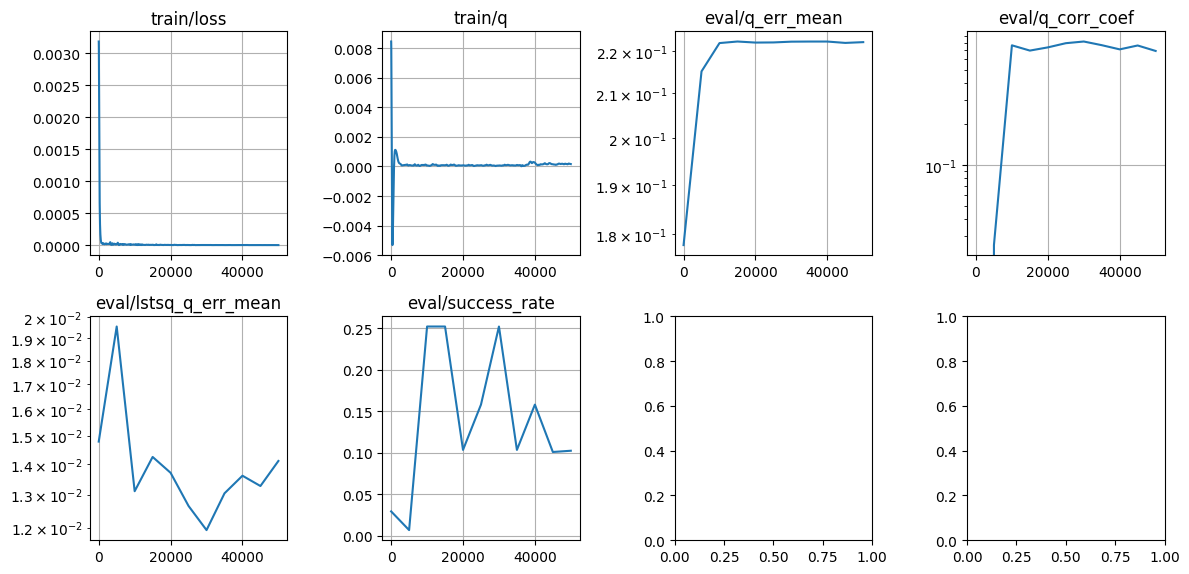

100%|██████████| 50000/50000 [02:44<00:00, 303.58it/s]


In [ ]:
batch_size = 1024
tau = 0.005
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

indicators = np.zeros((augmented_env.num_states, augmented_env.num_actions))
indicators[augmented_env.num_states - 2] = 1.
indicators = jnp.asarray(indicators)

key = jax.random.PRNGKey(np.random.randint(0, 2**32))
key, critic_key = jax.random.split(key)

example_batch = sample_batch(2)
example_batch = augment_batch(example_batch)
critic = Critic()
critic_params = critic.init(critic_key, example_batch['observations'], example_batch['actions'])
target_critic_params = copy.deepcopy(critic_params)

def loss_fn(params, target_params, batch):
  q = critic.apply(params, batch['observations'], batch['actions'])
  
  next_q1 = critic.apply(target_params, batch['next_observations'], jnp.zeros_like(batch['next_observations']))
  next_q2 = critic.apply(target_params, batch['next_observations'], jnp.ones_like(batch['next_observations']))
  next_q = jnp.maximum(next_q1, next_q2)
  target_q = (1 - discount) * batch['rewards'] + discount * batch['masks'] * next_q

  loss = jnp.mean((q - target_q) ** 2)
  
  scaled_q = q * discount + indicators[batch['observations'], batch['actions']] * (1 - discount)
  scaled_q = scaled_q * (1 + discount) / discount
  
  info = {
    'loss': loss,
    'q': scaled_q.mean(),
  }
  
  return loss, info

optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(critic_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, target_params, opt_state, batch):
  (loss, info), grads = grad_fn(params, target_params, batch)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  
  target_params = jax.tree_util.tree_map(
    lambda p, tp: p * tau + tp * (1 - tau),
    params, target_params,
  )
  
  return params, target_params, opt_state, loss, info

def compute_success_rate(params, num_eval_episodes=2000, max_episode_steps=1001):
  seed = 100
  augmented_eval_env = AugmentedRiverSwim(discount=discount, seed=seed, max_episode_steps=max_episode_steps)
  
  # compute the pi
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  q = critic.apply(params, obs, actions)
  q = q.reshape([augmented_env.num_states, augmented_env.num_actions])
  a = jnp.argmax(q, axis=-1)
  pi = jax.nn.one_hot(a, augmented_env.num_actions)
  pi = np.asarray(pi)

  # evaluation
  successes = []
  for _ in tqdm.trange(num_eval_episodes):
    traj_dataset = defaultdict(list)

    done = False
    obs = augmented_eval_env.reset()
    while not done:
      action = np.random.choice(np.arange(augmented_eval_env.num_actions), p=pi[obs])
      reward, next_obs, terminated, truncated = augmented_eval_env.step(action)
      done = terminated or truncated
      
      traj_dataset['observations'].append(obs)
      traj_dataset['actions'].append(action)
      traj_dataset['rewards'].append(reward)
      
      obs = next_obs
    successes.append(np.sum(traj_dataset['rewards']) >= 1.0)

  sr = np.mean(successes)

  return sr

def evaluate_fn(params):
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  gc_q = critic.apply(params, obs, actions)
  gc_q = gc_q.reshape([augmented_env.num_states, augmented_env.num_actions])
  # q = gc_q[:env.num_states]
  # q = q * (1 + discount) / discount
  scaled_gc_q = gc_q * discount + indicators * (1 - discount)
  scaled_gc_q = scaled_gc_q * (1 + discount) / discount
  q = scaled_gc_q[:env.num_states]
  
  slopes, intercepts = jnp.linalg.lstsq(
    jnp.stack([q.reshape(-1), jnp.ones_like(q.reshape(-1))], axis=1), 
    opt_q_square_discount.reshape(-1)
  )[0]
  lstsq_q = slopes * q + intercepts
  
  q_err_mean = jnp.mean(np.abs(q - opt_q_square_discount))
  q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q_square_discount.reshape(-1))[0, 1]
  lstsq_q_err_mean = jnp.mean(np.abs(lstsq_q - opt_q_square_discount))
  
  sr = compute_success_rate(params)
  
  info = {
    'q_err_mean': q_err_mean,
    'q_corr_coef': q_corr_coef,
    'lstsq_q_err_mean': lstsq_q_err_mean,
    'success_rate': sr,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_batch(batch_size)
  aug_batch = augment_batch(batch)
  critic_params, target_critic_params, opt_state, loss, info = update_fn(
    critic_params, target_critic_params, opt_state, aug_batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    eval_info = evaluate_fn(critic_params)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean', 'eval/q_corr_coef', 'eval/lstsq_q_err_mean'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [ ]:
sgcql_data_aug_metrics = metrics
print(sgcql_data_aug_metrics['eval/q_err_mean'][-1])
print(sgcql_data_aug_metrics['eval/q_corr_coef'][-1])
print(sgcql_data_aug_metrics['eval/lstsq_q_err_mean'][-1])
print(sgcql_data_aug_metrics['eval/success_rate'][-1])

[5.00000000e+04 2.22135484e-01]
[5.00000000e+04 6.93751454e-01]
[5.00000000e+04 1.41059104e-02]
[5.000e+04 1.025e-01]


In [ ]:
# evaluation the pi
obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
gc_q = critic.apply(critic_params, obs, actions)
gc_q = gc_q.reshape([augmented_env.num_states, augmented_env.num_actions])
gc_a = jnp.argmax(gc_q, axis=-1)
pi = jax.nn.one_hot(gc_a, augmented_env.num_actions)
pi = np.asarray(pi)

print("pi: ")
print(pi)


pi: 
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


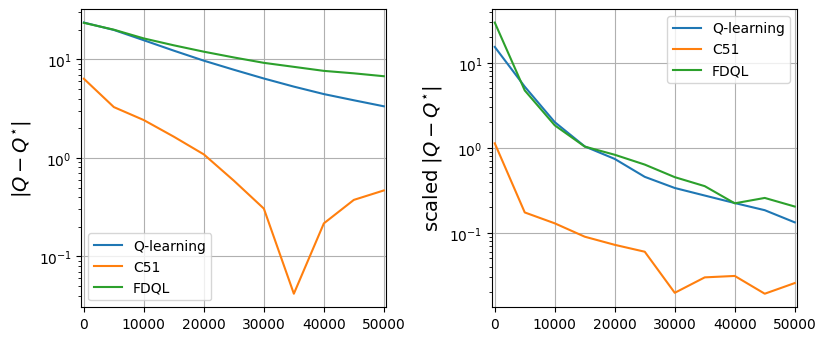

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3.2))

metric_name = 'eval/q_err_mean'
ax = axes[0]
for algo, metrics in zip(['Q-learning', 'C51', 'FDQL'], [q_learning_metrics, c51_metrics, fdql_metrics]):
    metrcs_arr = np.asarray(metrics[metric_name])
    l, = ax.plot(metrcs_arr[:, 0], metrcs_arr[:, 1], label=algo, zorder=3)
ax.set_ylabel(r'$| Q - Q^{\star} |$', fontsize=14)
ax.set_xlim([-4e2, 5e4 + 4e2])
ax.set_yscale('log')
ax.legend()
ax.grid(zorder=3)

metric_name = 'eval/scaled_q_err_mean'
ax = axes[1]
for algo, metrics in zip(['Q-learning', 'C51', 'FDQL'], [q_learning_metrics, c51_metrics, fdql_metrics]):
    metrcs_arr = np.asarray(metrics[metric_name])
    l, = ax.plot(metrcs_arr[:, 0], metrcs_arr[:, 1], label=algo, zorder=3)
ax.set_ylabel(r'scaled $| Q - Q^{\star} |$', fontsize=14)
ax.set_xlim([-4e2, 5e4 + 4e2])
ax.set_yscale('log')
ax.legend()

# ax.set_ylim([-5, 120 + 5])
# ax.set_yticks([0, 120])
# ax.yaxis.set_minor_locator(MultipleLocator(100))
ax.grid(zorder=3)     

fig.tight_layout(rect=(-0.026, -0.06, 1.02, 1.04))  # rect = (left, bottom, right, top), default: (0, 0, 1, 1)
# filepath = "/u/cz8792/research/ogbench/plot_scripts/figures/convergence_speed_ablation_lc.pdf"
# fig.savefig(filepath, dpi=150, bbox_inches="tight")
plt.show()
